In [1]:
from conditional_inference.quantile_unbiased import RQU

from functools import partial 

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from scipy.misc import derivative
from scipy.optimize import minimize, minimize_scalar
from scipy.stats import norm, rv_continuous
from sklearn.model_selection import train_test_split

# mu = np.arange(20)
mu = np.zeros(20)

sns.set()

In [2]:
def make_data(n_observations):
    X = np.repeat(np.identity(mu.shape[0]), n_observations, axis=0)
    y = np.array([
        norm(loc=mu_i, scale=np.sqrt(n_observations)).rvs(n_observations) for mu_i in mu
    ]).flatten()
    groups = X.argmax(axis=1)
    return X, y, groups

X, y, groups = make_data(1000)
X.shape, y.shape

((20000, 20), (20000,))

In [3]:
def sq_loss(beta, X, y):
    return ((X @ beta - y)**2).sum()

def quantile_loss(beta, X, y, q):
    err = y - (X @ beta)
    loss = (err * (q - (err < 0))).sum()
    return loss


class distribution(rv_continuous):
    def __init__(self, X_train, X_test, y_train):
        super().__init__()
        self.X_train = X_train.copy()
        self.X_test = X_test.copy()
        self.y_train = y_train.copy()
        self.x0 = np.array([1] + [0] * (X_train.shape[1] - 1))

    def mean(self):
        beta = minimize(sq_loss, x0=self.x0, args=(self.X_train, self.y_train)).x
        return (self.X_test @ beta)[0]

    def _ppf(self, q):
        def ppf(q_i):
            beta = minimize(quantile_loss, x0=self.x0, args=(self.X_train, self.y_train, q_i), method="Nelder-Mead").x
            return (self.X_test @ beta)[0]

        if not q.shape:
            return ppf(q)
        return np.array([ppf(q_i) for q_i in q])

    def _cdf(self, x):
        def cdf(x_i):
            return minimize_scalar(
                lambda q: (x_i - self.ppf(q))**2, 
                bounds=[0, 1], 
                method="Bounded"
            ).x

        if np.isscalar(x):
            return cdf(x)
        return np.array([cdf(x_i) for x_i in x])

    def _pdf(self, x):
        # TODO: this function doesn't perform well
        # alternative might be to use .rvs() method then kernel
        dq = 1e-2
        q = self.cdf(x)
        return 2 * dq / (self.ppf(q + dq) - self.ppf(q - dq))

In [4]:
class Estimator():
    def __init__(self, X, y, groups, estimator, n_samples=1000):
        def make_observation(X_train, X_test, y_train, y_test):
            stat_train = estimator(X_train, y_train)
            stat_test = estimator(X_test, y_test)
            order = (-stat_train).argsort()
            return [stat_train.mean()], stat_test[order]

        X_trans, Y_trans = [], []
        while len(X_trans) < n_samples:
            x_trans, y_trans = make_observation(
                *train_test_split(X, y, test_size=.5, stratify=groups)
            )
            X_trans.append(x_trans)
            Y_trans.append(y_trans)
        # transformed features used to train a regressor
        self.X_trans = sm.add_constant(X_trans)
        # transformed targets used to train a regressor
        self.Y_trans = np.array(Y_trans)
        # transformed features for the full dataset, used to produce final estimates
        stat_full = estimator(X, y)
        self.X_trans_full = np.array([[1, stat_full.mean()]])
        self.rank = stat_full.argsort()

    def get_distribution(self, rank=None, col=None):
        if rank is None:
            rank = 0 if col is None else self.rank[col]
        return distribution(self.X_trans, self.X_trans_full, self.Y_trans[:, rank])

    def get_distributions(self):
        return [self.get_distribution(rank=i) for i in self.rank[::-1]]

In [5]:
%%time

def compute_mean(X, y):
    return (X.T @ y) / X.sum(axis=0)

est = Estimator(X, y, groups, estimator=compute_mean)
est

Wall time: 24.3 s


c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:112: RuntimeWarning: Empty truncation set
  warnings.warn("Empty truncation set", RuntimeWarning)
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


<AxesSubplot:>

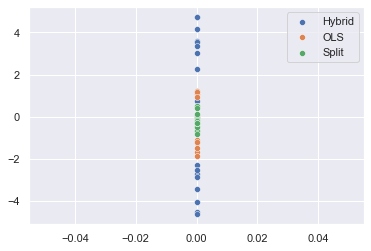

In [6]:
results = sm.OLS(y, X).fit().get_robustcov_results()
ols_estimates = results.params

rqu = RQU.from_results(results)
rqu_distributions = rqu.get_distributions(beta=.005)
rqu_estimates = [dist.median() for dist in rqu_distributions]

split_distributions = est.get_distributions()
split_estimates = np.array([dist.median() for dist in split_distributions])

sns.scatterplot(x=mu, y=rqu_estimates, label="Hybrid")
sns.scatterplot(x=mu, y=ols_estimates, label="OLS")
sns.scatterplot(x=mu, y=split_estimates, label="Split")
sns.lineplot(x=mu, y=mu)

<AxesSubplot:>

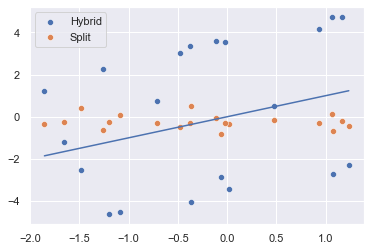

In [7]:
sns.scatterplot(x=ols_estimates, y=rqu_estimates, label="Hybrid")
sns.scatterplot(x=ols_estimates, y=split_estimates, label="Split")
sns.lineplot(x=ols_estimates, y=ols_estimates)

c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:112: RuntimeWarning: Empty truncation set
  warnings.warn("Empty truncation set", RuntimeWarning)
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


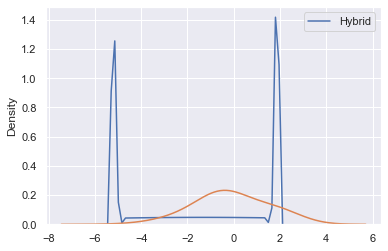

c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:112: RuntimeWarning: Empty truncation set
  warnings.warn("Empty truncation set", RuntimeWarning)
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


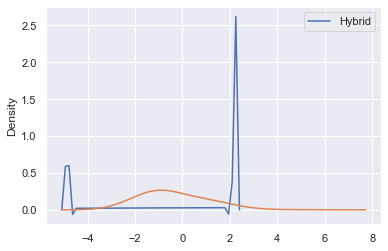

c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:112: RuntimeWarning: Empty truncation set
  warnings.warn("Empty truncation set", RuntimeWarning)
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:112: RuntimeWarning: Empty truncation set
  warnings.warn("Empty truncation set", RuntimeWarning)
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


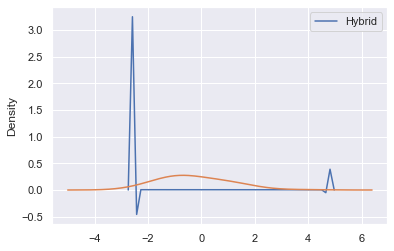

c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:112: RuntimeWarning: Empty truncation set
  warnings.warn("Empty truncation set", RuntimeWarning)
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


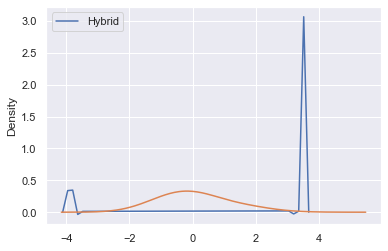

c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:112: RuntimeWarning: Empty truncation set
  warnings.warn("Empty truncation set", RuntimeWarning)
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


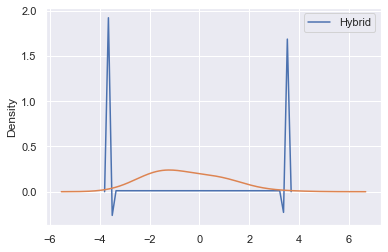

c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:112: RuntimeWarning: Empty truncation set
  warnings.warn("Empty truncation set", RuntimeWarning)
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:112: RuntimeWarning: Empty truncation set
  warnings.warn("Empty truncation set", RuntimeWarning)
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


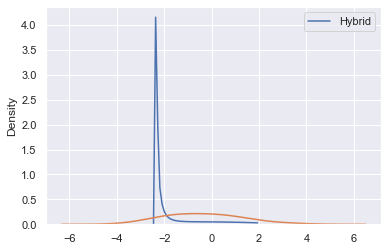

c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:112: RuntimeWarning: Empty truncation set
  warnings.warn("Empty truncation set", RuntimeWarning)
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


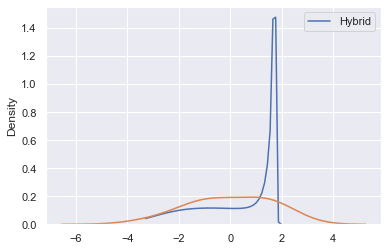

c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:112: RuntimeWarning: Empty truncation set
  warnings.warn("Empty truncation set", RuntimeWarning)
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:133: RuntimeWarning: Truncation set contains none of the distribution; results may be incorrect
  warnings.warn(


c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:112: RuntimeWarning: Empty truncation set
  warnings.warn("Empty truncation set", RuntimeWarning)
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:112: RuntimeWarning: Empty truncation set
  warnings.warn("Empty truncation set", RuntimeWarning)
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:133: RuntimeWarning: Truncation set contains none of the distribution; results may be incorrect
  warnings.warn(


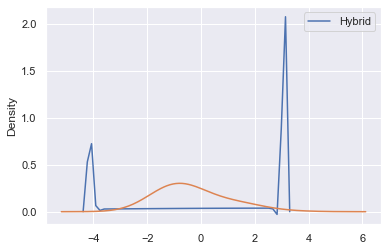

c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:112: RuntimeWarning: Empty truncation set
  warnings.warn("Empty truncation set", RuntimeWarning)
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:112: RuntimeWarning: Empty truncation set
  warnings.warn("Empty truncation set", RuntimeWarning)
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:133: RuntimeWarning: Truncation set contains none of the distribution; results may be incorrect
  warnings.warn(


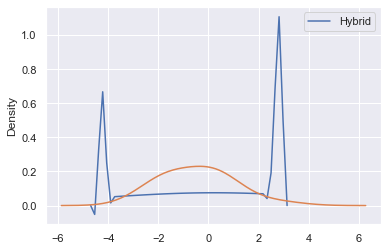

c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:112: RuntimeWarning: Empty truncation set
  warnings.warn("Empty truncation set", RuntimeWarning)
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:133: RuntimeWarning: Truncation set contains none of the distribution; results may be incorrect
  warnings.warn(


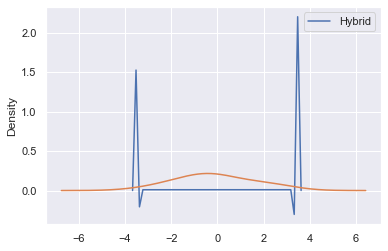

c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:112: RuntimeWarning: Empty truncation set
  warnings.warn("Empty truncation set", RuntimeWarning)
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


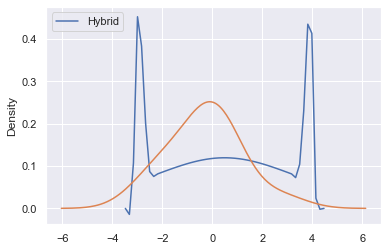

c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:112: RuntimeWarning: Empty truncation set
  warnings.warn("Empty truncation set", RuntimeWarning)
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:133: RuntimeWarning: Truncation set contains none of the distribution; results may be incorrect
  warnings.warn(


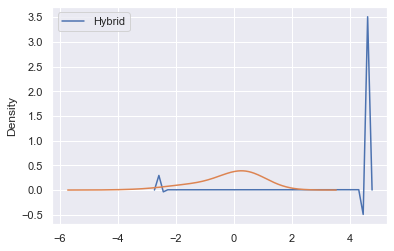

c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:112: RuntimeWarning: Empty truncation set
  warnings.warn("Empty truncation set", RuntimeWarning)
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


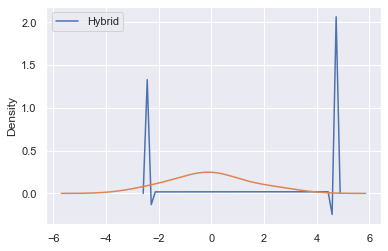

c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:112: RuntimeWarning: Empty truncation set
  warnings.warn("Empty truncation set", RuntimeWarning)
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


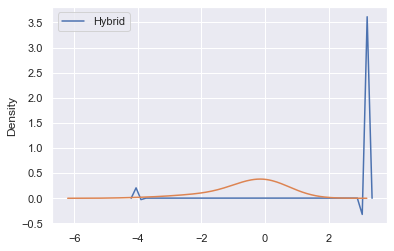

c:\users\dbspe\repos\ordered-inference\src\conditional_inference\quantile_unbiased.py:112: RuntimeWarning: Empty truncation set
  warnings.warn("Empty truncation set", RuntimeWarning)
C:\Users\DBSpe\anaconda3\envs\ordered-inference\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


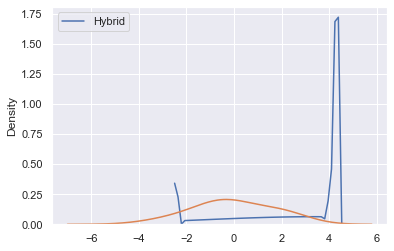

In [8]:
for rqu_dist, split_dist in zip(rqu_distributions, split_distributions):
    x = np.linspace(rqu_dist.ppf(.025), rqu_dist.ppf(.975))
    sns.lineplot(x=x, y=rqu_dist.pdf(x), label="Hybrid")

    sample = split_dist.rvs(size=200).reshape(-1, 1)
    sns.kdeplot(x=sample.squeeze(), bw_adjust=2, label="Split")

    plt.show()

In [9]:
# %%time

# x = np.linspace(0, 1)

# for rqu_dist, split_dist in zip(rqu_distributions, split_distributions):
#     sns.lineplot(x=rqu_dist.ppf(x), y=x, label="Hybrid")
#     sns.lineplot(x=split_dist.ppf(x), y=x, label="Split")
#     plt.show()